# Leaf Disease Classification Model

Applies transfer learning on pre-trained ImageNet models to identify if an image of a leaf is either healthy or diseased.

Training metrics are logged to TensorBoard for real-time monitoring.

`train_path` and `test_path` points to the directory containing the dataset. Each dataset contains two sub-directories for images of each class `healthy` and `diseased`.

```
train
|-- diseased
|   |-- diseased-0.jpg
|   |-- dieased-1.jpg
|   ...
|-- healthy
|   |-- healthy-0.jpg
|   |-- healthy-1.jpg
|   ...
```


In [1]:
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torch.onnx
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import os
from utils import train, test, inference

In [2]:
train_path = "dataset/train"
test_path = "dataset/test"

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Set seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)
generator = torch.Generator().manual_seed(1)

# Create output folder
if not os.path.exists("models"):
    os.makedirs("models")


## Choose Model

Run one of the following code blocks to select the pre-trained ImageNet model for transfer learning. Model parameters are frozen besides for the final linear layer. In the case of "Double FC Output", the two last linear layers are unfrozen.

### A. AlexNet

In [ ]:
model_name = "alexnet"
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 1)
model = model.to(device)

### B. ResNet18

In [ ]:
model_name = "resnet18"
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 1)
model = model.to(device)

### C. MobileNetv3-S

In [ ]:
model_name ="mobilenetv3-s"
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.classifier[3] = nn.Linear(1024, 1)
model = model.to(device)

### D. EfficientNet-b4

In [3]:
model_name ="efficientnet-b4"
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(1792, 1)
model = model.to(device)

### E. ResNet50

In [3]:
model_name = "resnet50"
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 1)
model = model.to(device)

### F. MobileNetv3-L

In [3]:
model_name ="mobilenetv3-l"
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)


for param in model.parameters():
    param.requires_grad = False

model.classifier[3] = nn.Linear(1280, 1)
model = model.to(device)

### G. MobileNetv3-L Double FC Output

In [5]:
model_name ="mobilenetv3-l-doublefc"
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)


for param in model.parameters():
    param.requires_grad = False

model.classifier[0] = nn.Linear(960, 1280)
model.classifier[3] = nn.Linear(1280, 1)
model = model.to(device)

### H. MobileNetv3-S Double FC Output

In [3]:
model_name ="mobilenetv3-s-doublefc"
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.classifier[0] = nn.Linear(576, 1024)
model.classifier[3] = nn.Linear(1024, 1)
model = model.to(device)

## Load Data

### Choose Transformation
Run one of the following code blocks to select the type of image augmentation to apply
#### Standard

In [9]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for ImageNet
])

#### AugMix

In [4]:
# Modified Shuffled Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for ImageNet
])

model_name += '-augmix'

## Train Model

Fine tunes the chosen pre-trained model. Trained models are checkpointed every 5 epochs to `./models`. Training metrics are logged to TensorBoard.

Models are trainsed using:
- Binary Cross Entropy Loss with Logits
- Adam Optimizer

In [ ]:
# Hyperparameters
batch_size = 64
epochs = 100
learning_rate = 1e-3

# Tensorboard writer
writer = SummaryWriter()

dataset = ImageFolder(train_path, transform=transform)
train_data, val_data = random_split(dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training {model_name}")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device, t, writer)
    test(val_dataloader, model, loss_fn, device, t, writer)

    if t % 5 == 0:
        print(f"Saving Checkpoint epoch: {t}")
        torch.save(model, f"models/{model_name}-{t}.pt")
    
print("Done!")

## Test Model

Tests the model from the given path on the following metrics:
1. Accuracy
2. F-1
3. Precision
4. Recall
5. Binary Cross Entropy Loss
6. Average run time for sample (either on GPU or CPU)

In [7]:
model_path = r"models\mobilenetv3-l-doublefc\mobilenetv3-l-doublefc-95.pt"

loss_fn = nn.BCEWithLogitsLoss()

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for alexNet
])

test_dataset = ImageFolder(test_path, test_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False)
model = torch.load(model_path)

### GPU Inference

In [8]:
inference(test_dataloader, model, loss_fn, "cuda")

Test Error: 
 Accuracy: 99.450%, Avg loss: 0.022524 
 Precision: 0.995348, Recall: 0.991313, f1: 0.993326 Exec Time: 0.012157



### CPU Inference

In [9]:
inference(test_dataloader, model, loss_fn, "cpu")

Test Error: 
 Accuracy: 99.450%, Avg loss: 0.022535 
 Precision: 0.995348, Recall: 0.991313, f1: 0.993326 Exec Time: 0.024576



## Export to ONNX
Given a path to a trained model, export as a ONNX model so it can be used with the ONNX runtime in JavaScript

ONNX runtime in JavaScript

In [ ]:
model_path = r'models\mobilenetv3-l\mobilenetv3-l-20.pt'

model = torch.load().to('cpu')

batch_size = 1    # just a random number
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)

torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "mobilenetv3-20.onnx",    # where to save the model (can be a file or file-like object)
                  input_names = ['image'],   # the model's input names
                  output_names = ['class'],  # the model's output names
                  dynamic_axes={'image' : {0 : 'batch_size'},    # variable length axes
                                'class' : {0 : 'batch_size'}})

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(r'converted\all_training_logs_in_one_file.csv')

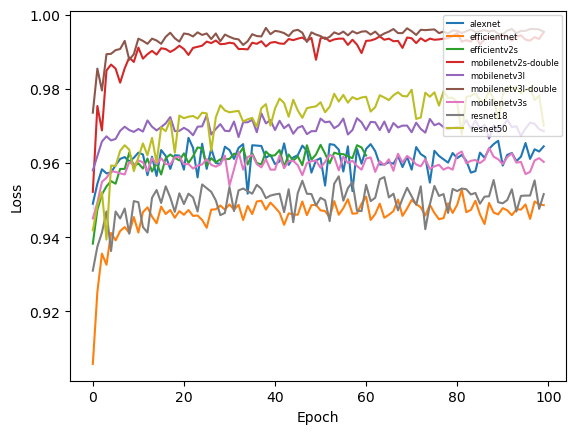

In [20]:
lossval_df = df[df['metric'] == 'Accuracy/val']
sns.lineplot(data=lossval_df, x='step', y='value', hue='run')

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc=1, prop={'size': 6})
plt.savefig('acc_val_curve.png')
plt.show()